In [1]:
DATA_PATH_JSON = "./NLP-Teknofest24/NLPJSON/"
DATA_PATH_TXT = "./NLP-Teknofest24/NLPTXT-1028 Etiketlenen Raporlar/"

In [2]:
import json
d_list = list()
for i in range(1,5):
    with open(DATA_PATH_JSON+str(i)+"/all.jsonl",'r', encoding="utf-8") as f:
        for a in f.readlines():
            d_list.append(json.loads(a))

In [3]:
import pandas as pd
import numpy as np
import re
import random

In [4]:
meta_data = pd.DataFrame(d_list)

In [5]:
meta_data = meta_data.drop(["Comments","id"],axis=1)

In [6]:
meta_data

,text,label
0,BİLATERAL MAMOGRAFİ İNCELEMESİ:\nHer iki memen...,"[[32, 47, ANAT], [48, 59, ANAT], [60, 66, OBS-..."
1,BİLATERAL MAMOGRAFİ İNCELEMESİNDE; \nBilateral...,"[[36, 50, ANAT], [51, 65, ANAT], [66, 75, OBS-..."
2,BİLATERAL MAMOGRAFİ İNCELEMESİ\nBilateral meme...,"[[31, 45, ANAT], [46, 60, ANAT], [61, 71, OBS-..."
3,BİLATERAL MAMOGRAFİ İNCELEMESİ\nHer iki memede...,"[[31, 45, ANAT], [46, 70, ANAT], [71, 78, ANAT..."
4,BİLATERAL MAMOGRAFİ İNCELEMESİ:\nHer iki meme ...,"[[32, 44, ANAT], [45, 59, ANAT], [60, 65, OBS-..."
...,...,...
1023,Unilateral Mammografi incelemesinde;\nSağ meme...,"[[37, 45, ANAT], [45, 55, ANAT], [56, 61, OBS-..."
1024,UNİLATERAL MAMOGRAFİ İNCELEMESİ\nSağ meme cilt...,"[[32, 40, ANAT], [41, 55, ANAT], [56, 65, OBS-..."
1025,UNİLATERAL MAMOGRAFİ İNCELEMESİ\nSağ meme cild...,"[[32, 40, ANAT], [41, 46, ANAT], [47, 54, OBS-..."
1026,UNİLATERAL MAMOGRAFİ İNCELEMESİ\nSol meme cilt...,"[[32, 40, ANAT], [41, 55, ANAT], [56, 62, OBS-..."


In [12]:
def count_obs(l : list) -> tuple[int,int,int]:
    obs_present_count = 0
    obs_uncertain_count = 0
    obs_absent_count = 0
    for i in l:
        if i[2] == "OBS-PRESENT":
            obs_present_count+=1
        elif i[2] == "OBS-UNCERTAIN":
            obs_uncertain_count+=1
        elif i[2] == "OBS-ABSENT":
            obs_absent_count+=1
    return obs_present_count,obs_uncertain_count,obs_absent_count

temp_df = pd.DataFrame(meta_data["label"].apply(count_obs).tolist(),columns=["OBS-PRESENT","OBS-UNCERTAIN","OBS-ABSENT"])
temp_df

,OBS-PRESENT,OBS-UNCERTAIN,OBS-ABSENT
0,7,0,3
1,4,0,3
2,4,0,5
3,7,0,4
4,10,1,5
...,...,...,...
1023,4,1,1
1024,7,0,0
1025,4,0,5
1026,12,0,0


In [8]:
meta_data =meta_data.join(temp_df)

In [9]:
meta_data["text"] = meta_data["text"].apply(lambda text: re.sub(r'[\s\t\n]+$', '', text))

In [10]:
class_label_list = []
counter = 0
def remove_sonuc(text : str) -> str:
    for i in ["SONUC","SONUÇ","Sonuc","Sonuç","sonuç","sonuc","RADYOLOJİK","Radyolojik","SONUç","Kategori","Katagori","BIRADS","BİRADS"]:
        s = re.search(i,text)
        if(s is not None):
            global counter
            counter+=1
            print(counter)
            num = re.search("[1,2,3,4,5]+",text[s.start():]).group()
            if len(num) == 2:
                num = num[-2]
            else: num = num[-1]
            class_label_list.append(int(num))
            return text[:s.start()]
    return text + " ?=========? "

In [11]:
meta_data["text"] = meta_data["text"].apply(remove_sonuc)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [12]:
meta_data["class"] = class_label_list

### Pivot_table analizi
* OBS-UNCERTAIN'dan bir sonuç çıkmaz muhtemelen
* OBS-ABSENT ve OBS-PRESENT için BI-RADS 1 ve geri kalan kategoriler arasında kayda değer bir fark var gibi görünüyor, ancak 2,3,4,5 arasında (artış trendi olsa da) o kadar da büyük bir fark yok, dolayısıyla nihai modelde text classification için NER'i belki sadece BI-RADS 1 veya daha yüksek diye ayırırken kullanabiliriz veya en kötü rapora ekleyip bunu denediğimizi ancak yeterince başarılı olmadığını belirtiriz özgünlük kısmında mesela.


In [66]:
pd.pivot_table(meta_data,values=["OP_per","OU_per","OA_per"],columns=["class"],aggfunc="median")

class,1,2,3,4,5
OA_per,0.113636,0.070802,0.066667,0.060000,0.049180
OP_per,0.088933,0.136364,0.143718,0.144928,0.147059
OU_per,0.000000,0.000000,0.000000,0.000000,0.000000


In [68]:
pd.pivot_table(meta_data,values=["OP_per","OU_per","OA_per"],columns=["class"],aggfunc="mean")

class,1,2,3,4,5
OA_per,0.117096,0.071551,0.067983,0.064987,0.057427
OP_per,0.091025,0.141657,0.143007,0.149570,0.163266
OU_per,0.000000,0.000505,0.002350,0.002341,0.001077


In [51]:
def approximate_token_count(text: str) -> int:
    return len(text.replace("\n"," ").split())

In [53]:
meta_data["token_count"] = meta_data["text"].apply(approximate_token_count)

In [56]:
meta_data["OP_per"] = meta_data["OBS-PRESENT"] / meta_data["token_count"]
meta_data["OU_per"] = meta_data["OBS-UNCERTAIN"] / meta_data["token_count"]
meta_data["OA_per"] = meta_data["OBS-ABSENT"] / meta_data["token_count"]

array([[<Axes: title={'center': 'OP_per'}>]], dtype=object)

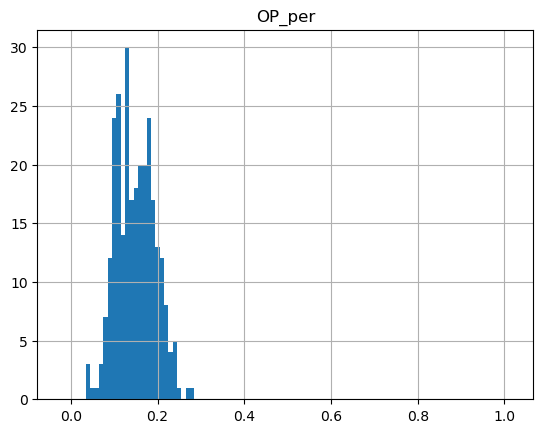

In [75]:
meta_data[meta_data["class"] == 5].hist("OP_per",bins=np.arange(-0.025, 1.025, 0.01))